In [ ]:
%%capture
!pip install koreanize-matplotlib
import koreanize_matplotlib

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 로드

In [ ]:
df_2024 = pd.read_csv("/content/drive/MyDrive/tour/cluster1.csv", index_col=0)

/tmp/ipython-input-46-3314172470.py:1: DtypeWarning: Columns (24,25,27,28,29,30,50,60,61,65,66,68,76,81,117,118,119,125,126,127,134,227,228,229,233,236,240,241,247,277,283) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2024 = pd.read_csv("/content/drive/MyDrive/tour/cluster1.csv", index_col=0)


In [ ]:
df_cluster1_2024 = df_2024.copy()
df_cluster1_2024.head()

,pnid,MVIT,RVIT,XRVIT,TYP,Q1,Q1_1a1,Q1_1a2,Q1_1a3,Q2a1,...,D_NUM,D_GUB,weight1,weight2,weight3,weight4,weight,cluster,재방문자,재방문의향긍정
9,69,1,1회,NaN,"개별여행 : 일정, 숙박 등 여행의 모든 준비를 직접 수행","친구, 친지 방문","한국에서 행사(가족행사, 스포츠 행사 등)가 있어서",NaN,NaN,NaN,...,1 회,개 별 여 행,1005.032741,NaN,NaN,NaN,1005.032741,1,False,False
19,85,1,1회,NaN,"개별여행 : 일정, 숙박 등 여행의 모든 준비를 직접 수행",사업 또는 전문 활동,NaN,NaN,NaN,NaN,...,1 회,개 별 여 행,1210.286770,NaN,NaN,NaN,1210.286770,1,False,False
28,101,3,3회,재방문,"개별여행 : 일정, 숙박 등 여행의 모든 준비를 직접 수행","친구, 친지 방문",과거 방문 경험이 좋아서,"한류 콘텐츠(K-pop, 드라마, 영화 등)를 접하고 나서",계획한 여행 경비에 적합한 여행지여서,태국,...,3 회,개 별 여 행,554.457606,NaN,NaN,NaN,554.457606,1,True,False
31,104,1,1회,NaN,"개별여행 : 일정, 숙박 등 여행의 모든 준비를 직접 수행","교육(어학 프로그램, 연수 등)",NaN,NaN,NaN,NaN,...,1 회,개 별 여 행,99.583958,NaN,NaN,NaN,99.583958,1,False,False
33,107,1,1회,NaN,"개별여행 : 일정, 숙박 등 여행의 모든 준비를 직접 수행","친구, 친지 방문",새로운 국가에 가고 싶어서,계획한 여행 경비에 적합한 여행지여서,NaN,일본,...,1 회,개 별 여 행,550.525754,NaN,NaN,NaN,550.525754,1,False,False


In [ ]:
df_cluster1_2024.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4158 entries, 9 to 16215
Columns: 405 entries, pnid to 재방문의향긍정
dtypes: bool(2), float64(138), int64(20), object(245)
memory usage: 12.8+ MB


#### 가중치 부여

| 항목                       | 적용 방식                   |
| ------------------------ | ----------------------- |
| 수치형 변수 (예: 체류일수)         | **가중 평균**               |
| 이진 변수 (예: 재방문 여부)        | **가중 비율**               |
| 범주형 변수 (예: 방문 목적, 여행 유형) | **가중 빈도** (→ 비율 시각화 가능) |


In [ ]:
# 변수 정보 요약
variable_summary = pd.DataFrame({
    "컬럼명": df_cluster1_2024.columns,
    "dtype": df_cluster1_2024.dtypes.values,
    "결측치수": df_cluster1_2024.isnull().sum().values,
    "고유값 수": df_cluster1_2024.nunique().values
})

# 변수 유형 분류 함수
def classify_variable(row):
    dtype = row["dtype"]
    nunique = row["고유값 수"]

    if pd.api.types.is_numeric_dtype(dtype):
        if nunique == 2:
            return "이진 변수"
        else:
            return "수치형 변수"
    elif pd.api.types.is_bool_dtype(dtype):
        return "이진 변수"
    else:
        if nunique == 2:
            return "이진 변수"
        else:
            return "범주형 변수"

# 변수 유형 적용
variable_summary["변수유형"] = variable_summary.apply(classify_variable, axis=1)

# 정리된 결과 보기
variable_summary = variable_summary[["컬럼명", "변수유형", "dtype", "고유값 수", "결측치수"]]
variable_summary.head(50)  # 또는 display(variable_summary)

,컬럼명,변수유형,dtype,고유값 수,결측치수
0,pnid,수치형 변수,int64,4158,0
1,MVIT,수치형 변수,int64,21,0
2,RVIT,범주형 변수,object,4,0
3,XRVIT,범주형 변수,object,1,2639
4,TYP,범주형 변수,object,3,0
5,Q1,범주형 변수,object,5,0
6,Q1_1a1,범주형 변수,object,11,1202
7,Q1_1a2,범주형 변수,object,11,1836
8,Q1_1a3,범주형 변수,object,11,2338
9,Q2a1,범주형 변수,object,14,1745


# 국가

## **가설**
- 방문객 수가 많은 나라는 만족도가 높을 것이다.
- 국가별로 선호하는 관광 콘텐츠(세부 만족도 항목)는 다를 것이다.

### **국가별 방문 수**

In [ ]:
df_cluster1_2024['D_NAT'] = df_cluster1_2024['D_NAT'].str.replace(' ', '', regex=False)

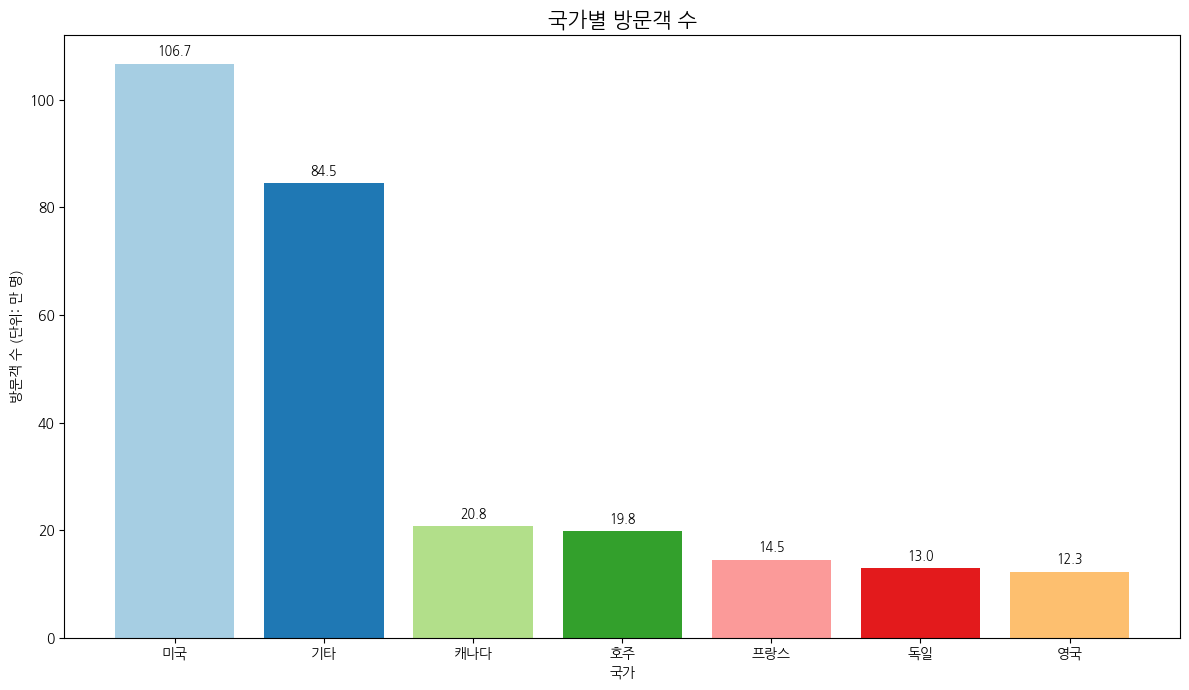

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 국가별 가중 방문객 수 집계
country_weighted = df_cluster1_2024.groupby("D_NAT")["weight"].sum().reset_index()
country_weighted.columns = ["국가", "가중방문객수"]
country_weighted["가중방문객수_만명"] = (country_weighted["가중방문객수"] / 10000).round(1)

# 가중방문객수 기준으로 정렬
country_weighted_sorted = country_weighted.sort_values(by="가중방문객수", ascending=False)

# 색상 팔레트 자동 생성
palette = sns.color_palette("Paired", n_colors=len(country_weighted_sorted))

# 시각화
palette = sns.color_palette("Paired", n_colors=len(country_weighted_sorted))

plt.figure(figsize=(12, 7))
bars = plt.bar(country_weighted_sorted["국가"], country_weighted_sorted["가중방문객수_만명"], color=palette)

plt.ylabel("방문객 수 (단위: 만 명)")
plt.xlabel("국가")
plt.title("국가별 방문객 수", fontsize=15)
plt.xticks(rotation=0)

# 수치 라벨 표시 (막대 위에)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1,
             f"{height:.1f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


### 국가별 만족도

In [ ]:
# 만족도 매핑 딕셔너리 정의
satisfaction_map = {
    "⑤ 매우 만족": 5,
    "④ 만족": 4,
    "③ 보통": 3,
    "② 불만족": 2,
    "① 매우 불만족": 1
}

# Q11 문자형 → 숫자형 변환
df_cluster1_2024["Q11_num"] = df_cluster1_2024["Q11"].map(satisfaction_map)

# 국가별 평균 만족도 계산
satisfaction_by_country = df_cluster1_2024.groupby("D_NAT")["Q11_num"].mean().reset_index()
satisfaction_by_country.columns = ["국가", "평균만족도"]
satisfaction_by_country = satisfaction_by_country.sort_values(by="평균만족도", ascending=False)

# 히트맵용 데이터 준비
heatmap_data = satisfaction_by_country.set_index("국가")



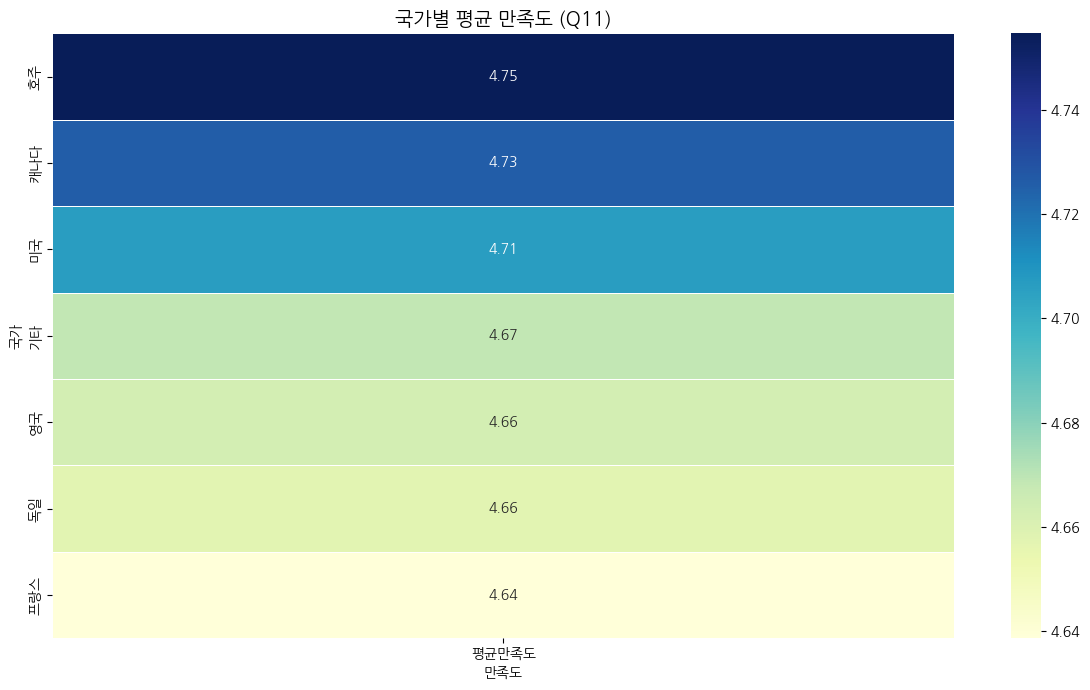

In [ ]:
# 시각화
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title("국가별 평균 만족도 (Q11)", fontsize=14)
plt.xlabel("만족도")
plt.ylabel("국가")
plt.tight_layout()
plt.show()

### 국가별 세부 만족도

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 만족도 문자 → 숫자 매핑
satisfaction_map = {
    "⑤ 매우 만족": 5,
    "④ 만족": 4,
    "③ 보통": 3,
    "② 불만족": 2,
    "① 매우 불만족": 1
}

# 만족도 변수 목록
satisfaction_cols = [f"Q12a{str(i).zfill(2)}" for i in range(1, 28)]

# 항목명 매핑
q12a_labels = {
    "Q12a01": "식도락(음식/미식) 관광",
    "Q12a02": "쇼핑",
    "Q12a03": "자연경관 감상",
    "Q12a04": "휴양/휴식(웰니스)",
    "Q12a05": "고궁/역사 유적지 방문",
    "Q12a06": "전통문화체험 (한복체험, 태권도, 한국 음식 만들기 등)",
    "Q12a07": "박물관, 전시관 관람",
    "Q12a08": "K-POP/한류스타 관련 공연장 및 드라마/영화 촬영지 방문",
    "Q12a09": "연극, 뮤지컬, 발레 등 공연 관람",
    "Q12a10": "지역 축제 참여",
    "Q12a11": "유흥(나이트라이프 활동 및 카지노)",
    "Q12a12": "오락(놀이공원 및 테마파크 방문 등",
    "Q12a13": "뷰티/미용 관광(마사지샵, 헤어샵, 네일케어 등 방문)",
    "Q12a14": "치료/건강검진(피부과, 성형외과, 내외과 입원, 수술 등)",
    "Q12a15": "스포츠/레포츠 관람 (야구, 축구, 농구 등)",
    "Q12a16": "스포츠/레포츠 참가 (스키, 수영, 골프, 캠핑, 등반, 자전거, 래프팅 등)",
    "Q12a17": "출입국 절차",
    "Q12a18": "언어소통",
    "Q12a19": "치안",
    "Q12a20": "여행 경비",
    "Q12a21": "숙박 시설",
    "Q12a22": "대중교통",
    "Q12a23": "길 찾기",
    "Q12a24": "관광안내서비스",
    "Q12a25": "모바일/인터넷 편의",
    "Q12a26": "디지털 관광 정보",
    "Q12a27": "한국여행사/가이드"
}

# 누락 항목은 기본 변수명 유지
for col in satisfaction_cols:
    if col not in q12a_labels:
        q12a_labels[col] = col

# 매핑 및 전처리
df_satis = df_cluster1_2024[["D_NAT"] + satisfaction_cols].copy()
df_satis[satisfaction_cols] = df_satis[satisfaction_cols].applymap(satisfaction_map.get)

# 국가별 평균 계산
mean_by_country = df_satis.groupby("D_NAT")[satisfaction_cols].mean()

# 컬럼명 교체
mean_by_country.rename(columns=q12a_labels, inplace=True)

/tmp/ipython-input-35-3358313621.py:55: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_satis[satisfaction_cols] = df_satis[satisfaction_cols].applymap(satisfaction_map.get)


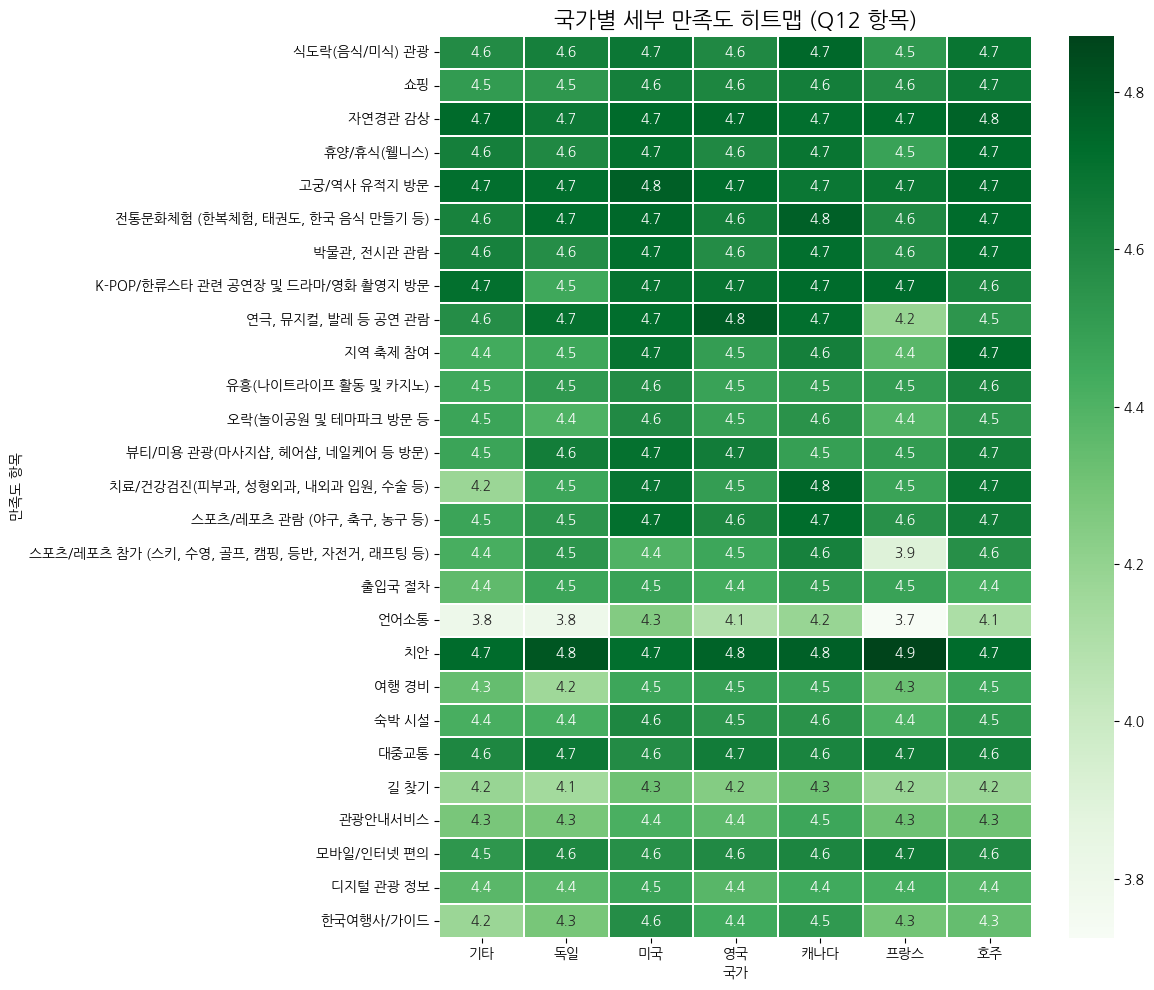

In [ ]:
# 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(mean_by_country.T, annot=True, fmt=".1f", cmap="Greens", linewidths=0.3)

plt.title("국가별 세부 만족도 히트맵 (Q12 항목)", fontsize=16)
plt.xlabel("국가")
plt.ylabel("만족도 항목")
plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


# **방문 목적**
1. 가중빈도란?
- 실제 추정 관광객 수

## **가설**
- 방한 목적에 따라 전체 만족도(Q11) 와 활동별 만족도(Q12)가 다를 것이다.
- 추가적으로 생각 예정!

In [ ]:
# 방문 목적별 가중 빈도 및 비율 계산
q1_weighted = df_cluster1_2024.groupby("Q1", dropna=False)["weight"].sum().reset_index()
q1_weighted.columns = ["방문목적", "가중빈도"]
q1_weighted["비율(%)"] = (q1_weighted["가중빈도"] / q1_weighted["가중빈도"].sum()) * 100

# 가중빈도는 정수로 반올림, 비율은 소수점 2자리 반올림
q1_weighted["가중빈도"] = q1_weighted["가중빈도"].round(0).astype(int)
q1_weighted["비율(%)"] = q1_weighted["비율(%)"].round(2)

# 가중빈도 기준 내림차순 정렬
q1_weighted_sorted = q1_weighted.sort_values(by="가중빈도", ascending=False).reset_index(drop=True)

# 결과 출력
q1_weighted_sorted


,방문목적,가중빈도,비율(%)
0,"여가, 위락, 휴식",1431783,52.69
1,사업 또는 전문 활동,665781,24.50
2,"친구, 친지 방문",476714,17.54
3,"교육(어학 프로그램, 연수 등)",92394,3.40
4,기타,50817,1.87


### **방문 목적 분포**

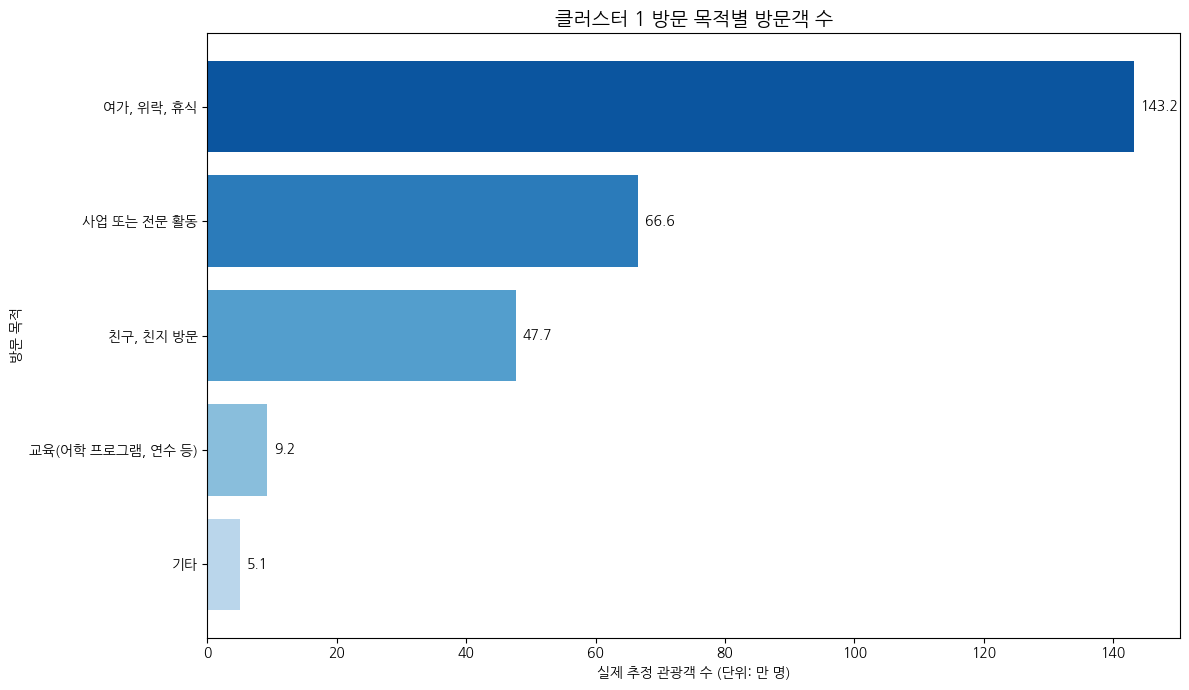

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화용 데이터 준비
top_q1 = q1_weighted_sorted.copy()
top_q1["가중빈도_만명"] = top_q1["가중빈도"] / 10000  # 단위: 만 명

# 자동 색상 개수 적용
palette = sns.color_palette("Blues_r")

plt.figure(figsize=(12, 7))
bars = plt.barh(top_q1["방문목적"], top_q1["가중빈도_만명"], color=palette)

# 축 설정
plt.xlabel("실제 추정 관광객 수 (단위: 만 명)")
plt.ylabel("방문 목적")
plt.title("클러스터 1 방문 목적별 방문객 수", fontsize=14)
plt.gca().invert_yaxis()

# 막대 끝 수치 표시
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2,
             f"{width:.1f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

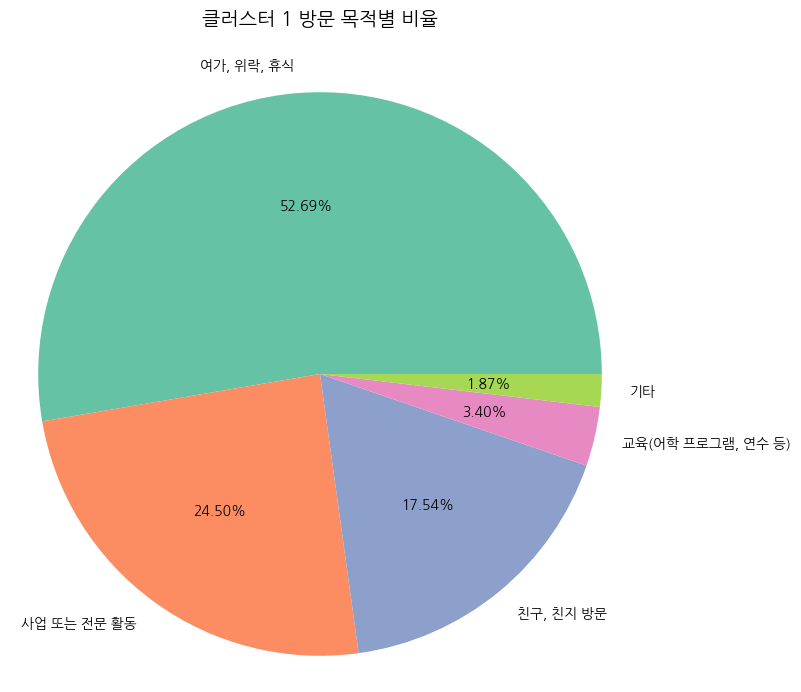

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

palette = sns.color_palette("Set2", n_colors=len(top_q1))

plt.figure(figsize=(8, 8))
plt.pie(
    top_q1["비율(%)"],
    labels=top_q1["방문목적"],
    autopct="%.2f%%",
    startangle=0,
    colors=palette
)
plt.title("클러스터 1 방문 목적별 비율", fontsize=14, pad=30)
plt.axis("equal")
plt.show()


### **방문 목적별 전반적 만족도 분포**

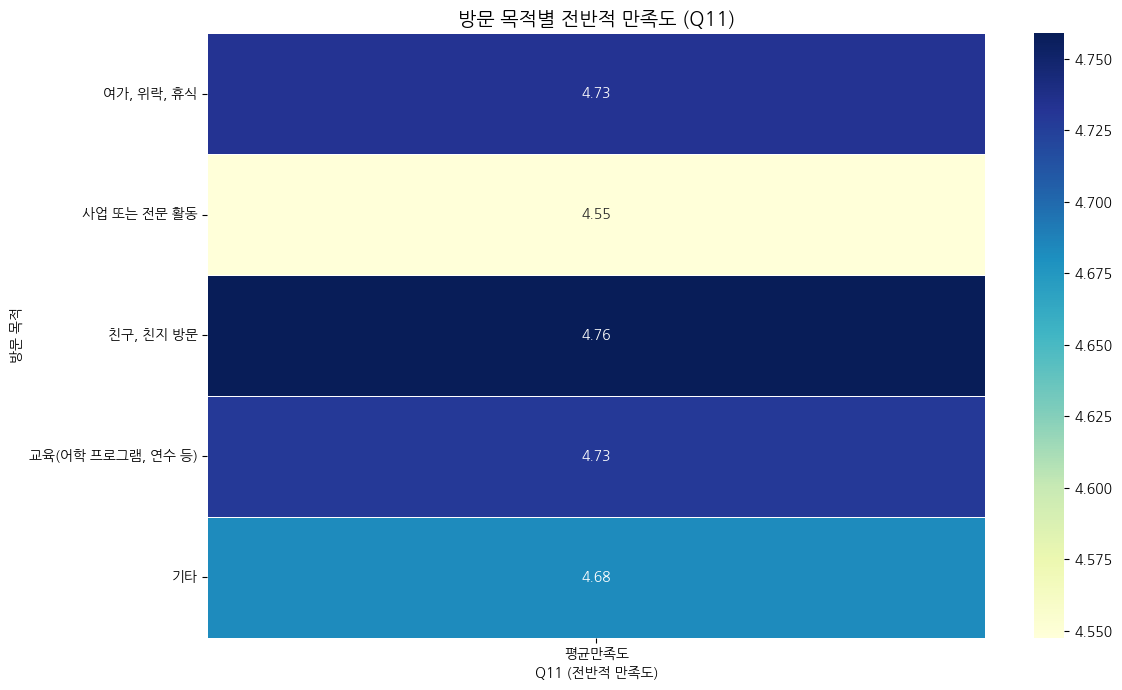

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 0: 가중치 기준 목적별 비중 계산
purpose_weight = df_cluster1_2024.groupby("Q1")["weight"].sum().reset_index()
purpose_weight.columns = ["방문목적", "총가중치"]

# 기존 평균 만족도와 병합
df_q1_q11 = df_cluster1_2024[["Q1", "Q11", "weight"]].copy()
df_q1_q11["Q11_score"] = df_q1_q11["Q11"].map(satisfaction_map)

# 평균 만족도 계산 (단순 평균)
mean_q11_by_purpose = df_q1_q11.groupby("Q1")["Q11_score"].mean().reset_index()
mean_q11_by_purpose.columns = ["방문목적", "평균만족도"]

# 가중치와 결합 후 비중 높은 순 정렬
mean_q11_by_purpose = pd.merge(mean_q11_by_purpose, purpose_weight, on="방문목적")
mean_q11_by_purpose = mean_q11_by_purpose.sort_values(by="총가중치", ascending=False)

# 히트맵용 데이터 전처리
heatmap_data = mean_q11_by_purpose.set_index("방문목적")[["평균만족도"]]

# 히트맵 시각화
plt.figure(figsize=(12, 7))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title("방문 목적별 전반적 만족도 (Q11)", fontsize=14)
plt.xlabel("Q11 (전반적 만족도)")
plt.ylabel("방문 목적")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



### **방문 목적별 전반적 만족도 분포 (가중치 적용)**

/tmp/ipython-input-18-1167781623.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_q11_by_purpose = df_q1_q11.groupby("Q1").apply(weighted_mean).reset_index()


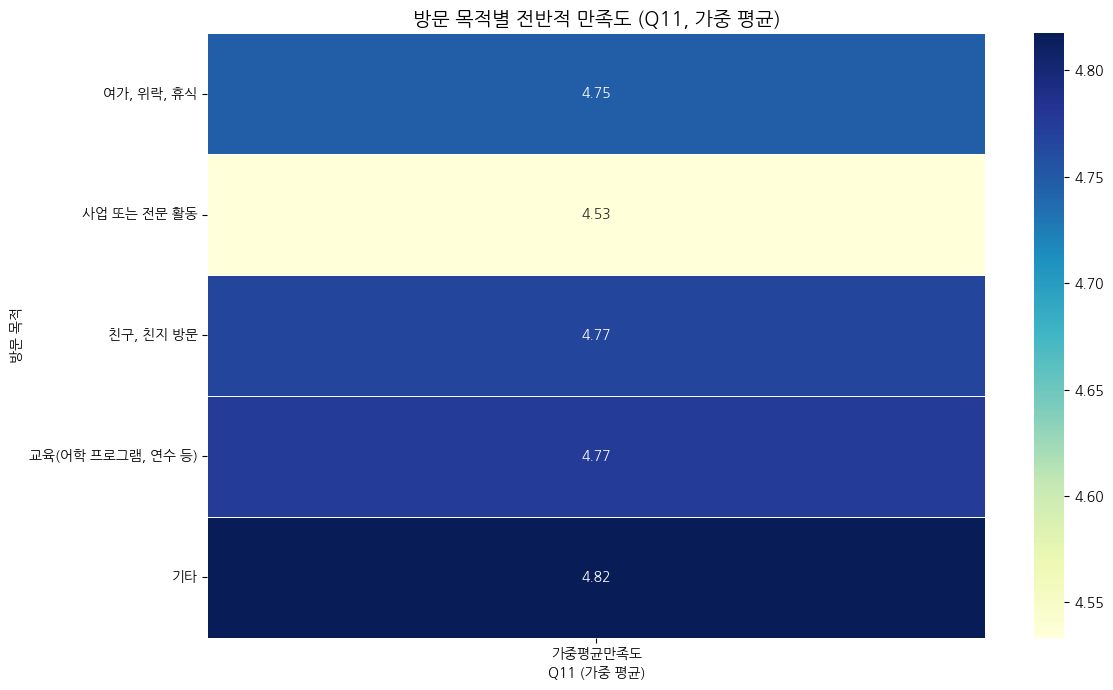

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Q1, Q11, weight 열 추출 및 변환
df_q1_q11 = df_cluster1_2024[["Q1", "Q11", "weight"]].copy()
df_q1_q11["Q11_score"] = df_q1_q11["Q11"].map(satisfaction_map)

# Step 2: 가중 평균 계산 함수 정의
def weighted_mean(group):
    return (group["Q11_score"] * group["weight"]).sum() / group["weight"].sum()

# Step 3: Q1(방문목적)별 가중 평균 계산
weighted_q11_by_purpose = df_q1_q11.groupby("Q1").apply(weighted_mean).reset_index()
weighted_q11_by_purpose.columns = ["방문목적", "가중평균만족도"]

# Step 4: Q1별 가중치 총합 기준 정렬
weight_sum = df_q1_q11.groupby("Q1")["weight"].sum().reset_index()
weight_sum.columns = ["방문목적", "총가중치"]

# 병합 후 정렬
weighted_q11_by_purpose = pd.merge(weighted_q11_by_purpose, weight_sum, on="방문목적")
weighted_q11_by_purpose = weighted_q11_by_purpose.sort_values(by="총가중치", ascending=False)

# Step 5: 히트맵용 데이터 변환
heatmap_data = weighted_q11_by_purpose.set_index("방문목적")[["가중평균만족도"]]

# Step 6: 히트맵 시각화
plt.figure(figsize=(12, 7))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title("방문 목적별 전반적 만족도 (Q11, 가중 평균)", fontsize=14)
plt.xlabel("Q11 (가중 평균)")
plt.ylabel("방문 목적")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### 단순 평균 vs 가중 평균 차이

- **"단순 평균"**과 **"가중 평균"**의 차이는 **응답자의 대표성(`weight`)을 반영하느냐**의 차이입니다.

<br>

1. 단순 평균 (Simple Mean)
- 모든 응답자를 **동등하게 1명씩** 취급한다.

- 예시:

| 방문 목적 | Q11 점수 | weight |
|-----------|-----------|--------|
| 쇼핑      | 4.0       | 10,000 |
| 쇼핑      | 2.0       | 1,000  |

- → 단순 평균: (4.0 + 2.0) / 2 = 3.0
- 실제로는 첫 번째 응답자가 **10배 더 많은 사람을 대표**하는데 무시됨!

<br>

2. 가중 평균 (Weighted Mean)
- 응답자별 `weight`만큼 **실제 대표 인원수**를 반영하여 평균을 구한다.
- **공식:**
$$
\text{가중 평균} = \frac{4.0 \times 10000 + 2.0 \times 1000}{10000 + 1000} = \frac{40000 + 2000}{11000} = 3.636
$$
- → 실제 관광객 수를 기반으로 한 실질적 만족도 평균


# **재방문 의사**

## **가설**
- 전반적 만족도(Q11)가 높을수록 재방문 의향(Q13)도 높을 것이다.
- 활동별 세부 만족도(Q12)가 Q13에 큰 영향을 미칠 것이다. (애매한 가설인가?)

In [ ]:
df_cluster1_2024["Q13"].describe()

,Q13
count,4158
unique,5
top,⑤ 매우 그렇다
freq,2582


### **재방문 의사 분포**

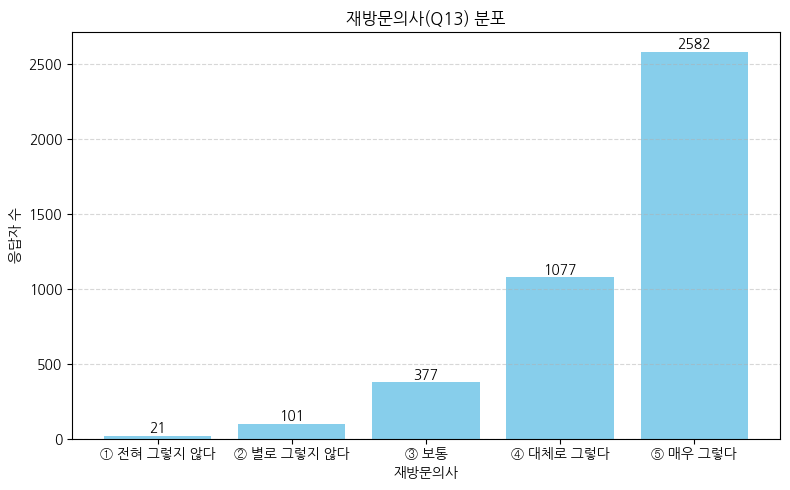

In [ ]:
import matplotlib.pyplot as plt

# 빈도표
q13_counts = df_cluster1_2024["Q13"].value_counts().sort_index()

# 시각화
plt.figure(figsize=(8, 5))
bars = plt.bar(q13_counts.index.astype(str), q13_counts.values, color='skyblue')
plt.xlabel("재방문의사")
plt.ylabel("응답자 수")
plt.title("재방문의사(Q13) 분포")
plt.grid(axis="y", linestyle="--", alpha=0.5)

# 막대 끝에 수치 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 3, f"{height}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


### **재방문 의사 분포 (가중평균)**

In [ ]:
# 매핑 딕셔너리 (앞의 숫자를 유니코드 숫자 기호로 맞춤)
q13_map = {
    "⑤ 매우 그렇다": 5,
    "④ 대체로 그렇다": 4,
    "③ 보통": 3,
    "② 별로 그렇지 않다": 2,
    "① 전혀 그렇지 않다": 1
}

# 매핑 적용
df_cluster1_2024["Q13_score"] = df_cluster1_2024["Q13"].map(q13_map)

# 결측 제거 후 가중 평균 계산 (전체 weight 사용)
valid = df_cluster1_2024.dropna(subset=["Q13_score", "weight"])
weighted_mean_q13 = (valid["Q13_score"] * valid["weight"]).sum() / valid["weight"].sum()
print(f"📌 재방문의사(Q13)의 전체 가중 평균: {weighted_mean_q13:.2f}")


📌 재방문의사(Q13)의 전체 가중 평균: 4.47


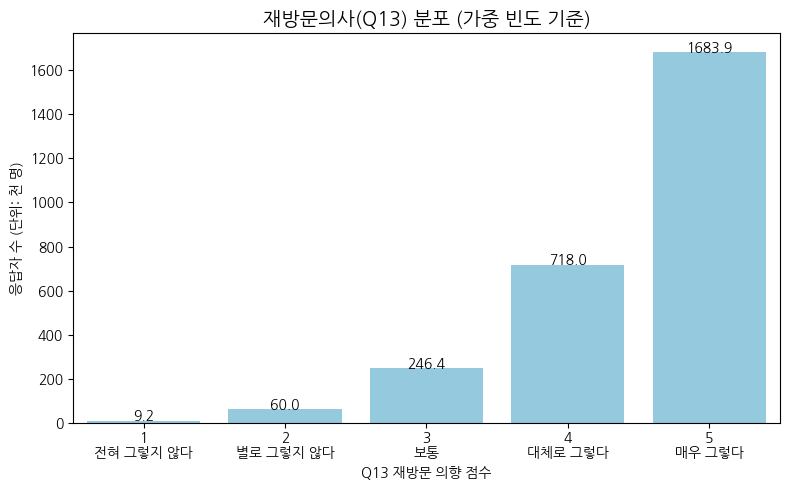

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📌 Q13 값 → 점수로 매핑 (이미 했더라도 중복 적용 무방)
q13_map = {
    "① 전혀 그렇지 않다": 1,
    "② 별로 그렇지 않다": 2,
    "③ 보통": 3,
    "④ 대체로 그렇다": 4,
    "⑤ 매우 그렇다": 5
}
df_cluster1_2024["Q13_score"] = df_cluster1_2024["Q13"].map(q13_map)

# 📌 Q13별 가중 빈도 집계
q13_dist = (
    df_cluster1_2024.groupby("Q13_score")["weight"]
    .sum()
    .reset_index()
    .sort_values(by="Q13_score")
)
q13_dist["weight_천명"] = (q13_dist["weight"] / 1000).round(1)  # 단위: 천명

# 📌 시각화
plt.figure(figsize=(8, 5))
sns.barplot(data=q13_dist, x="Q13_score", y="weight_천명", color="skyblue")

# 수치 라벨 표시
for i, row in q13_dist.iterrows():
    plt.text(i, row["weight_천명"] + 1, f"{row['weight_천명']:.1f}", ha="center", fontsize=10)

plt.title("재방문의사(Q13) 분포 (가중 빈도 기준)", fontsize=14)
plt.xlabel("Q13 재방문 의향 점수")
plt.ylabel("응답자 수 (단위: 천 명)")
plt.xticks([0, 1, 2, 3, 4], labels=["1\n전혀 그렇지 않다", "2\n별로 그렇지 않다", "3\n보통", "4\n대체로 그렇다", "5\n매우 그렇다"])
plt.tight_layout()
plt.show()


### **재방문 의사 비율 분포 (가중평균)**

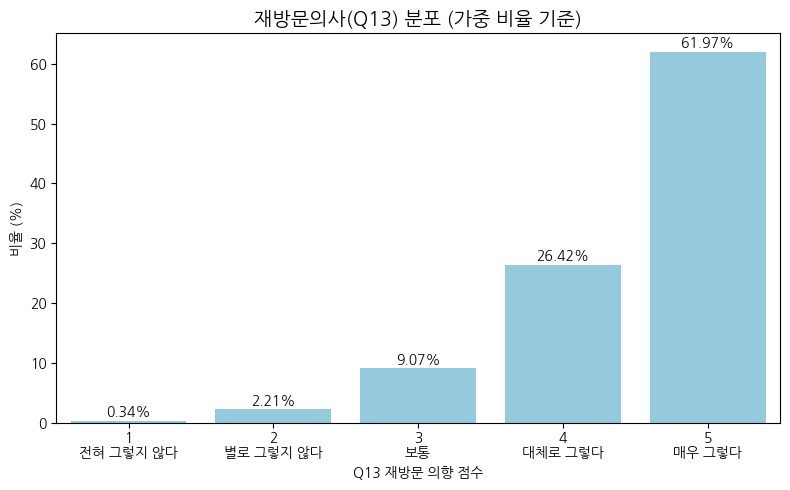

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📌 Q13 값 → 점수로 매핑 (이미 되어있으면 생략 가능)
q13_map = {
    "① 전혀 그렇지 않다": 1,
    "② 별로 그렇지 않다": 2,
    "③ 보통": 3,
    "④ 대체로 그렇다": 4,
    "⑤ 매우 그렇다": 5
}
df_cluster1_2024["Q13_score"] = df_cluster1_2024["Q13"].map(q13_map)

# 📌 Q13별 가중 비율 계산
q13_dist = (
    df_cluster1_2024.groupby("Q13_score")["weight"]
    .sum()
    .reset_index()
    .sort_values(by="Q13_score")
)
total_weight = q13_dist["weight"].sum()
q13_dist["비율(%)"] = (q13_dist["weight"] / total_weight * 100).round(2)

# 📌 시각화
plt.figure(figsize=(8, 5))
sns.barplot(data=q13_dist, x="Q13_score", y="비율(%)", color="skyblue")

# 수치 라벨 표시
for i, row in q13_dist.iterrows():
    plt.text(i, row["비율(%)"] + 0.8, f"{row['비율(%)']:.2f}%", ha="center", fontsize=10)

plt.title("재방문의사(Q13) 분포 (가중 비율 기준)", fontsize=14)
plt.xlabel("Q13 재방문 의향 점수")
plt.ylabel("비율 (%)")
plt.xticks([0, 1, 2, 3, 4], labels=[
    "1\n전혀 그렇지 않다", "2\n별로 그렇지 않다", "3\n보통", "4\n대체로 그렇다", "5\n매우 그렇다"
])
plt.tight_layout()
plt.show()


In [ ]:
# 국가별 가중 평균
grouped = df_cluster1_2024.groupby("D_NAT")
weighted_mean_q13_by_nat = (
    grouped.apply(lambda g: (g["Q13_score"] * g["weight"]).sum() / g["weight"].sum())
    .reset_index()
    .rename(columns={0: "Q13_가중평균"})
    .sort_values(by="Q13_가중평균", ascending=False)
)


/tmp/ipython-input-24-35345255.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped.apply(lambda g: (g["Q13_score"] * g["weight"]).sum() / g["weight"].sum())


### **국가별 재방문 의사 분포 (가중평균)**

/tmp/ipython-input-25-2566741084.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_data, y="D_NAT", x="Q13_가중평균", palette="Blues_d")


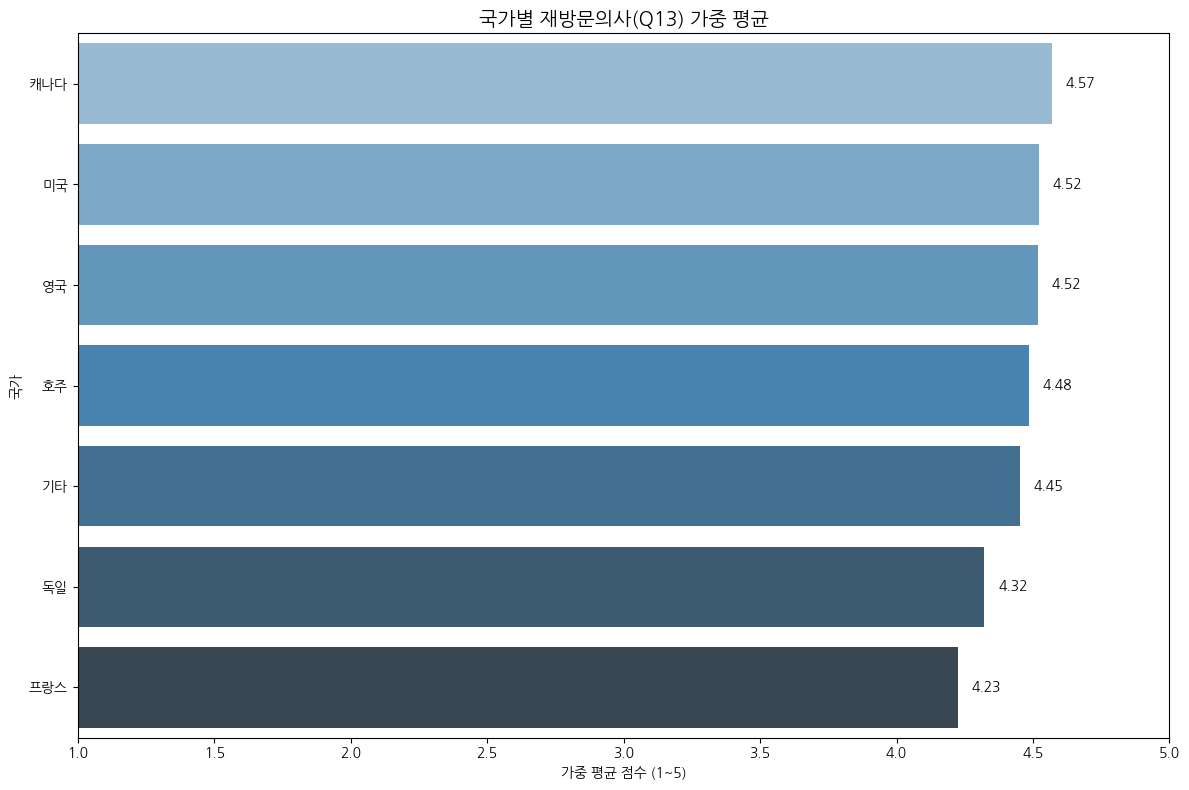

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화용 데이터 정제
plot_data = weighted_mean_q13_by_nat.copy()

plt.figure(figsize=(12, 8))
ax = sns.barplot(data=plot_data, y="D_NAT", x="Q13_가중평균", palette="Blues_d")

# 수치 라벨 표시: ax.patches 사용
for bar in ax.patches:
    x = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    ax.text(x + 0.05, y, f"{x:.2f}", va='center', fontsize=10)

plt.title("국가별 재방문의사(Q13) 가중 평균", fontsize=14)
plt.xlabel("가중 평균 점수 (1~5)")
plt.ylabel("국가")
plt.xlim(1, 5)
plt.tight_layout()
plt.show()


### **만족도별 재방문 의사 분포 (가중평균)**

| 구역           | 의미                                                |
| ------------ | ------------------------------------------------- |
| Q11 ↑, Q13 ↓ | 만족도는 높지만 재방문의사는 낮음 → 거리, 비자, 비용 등의 **구조적 장벽 가능성** |
| Q11 ↓, Q13 ↓ | 만족도도 낮고 재방문의사도 낮음 → **서비스 품질 개선 필요**              |
| Q11 ↑, Q13 ↑ | **핵심 타겟 국가**로 유지 강화                               |
| Q11 ↓, Q13 ↑ | 잠재적으로 **문화/기대치 차이 고려** 필요                         |


In [ ]:
# 점수 매핑 딕셔너리
q11_map = {
    "① 매우 불만족": 1,
    "② 불만족": 2,
    "③ 보통": 3,
    "④ 만족": 4,
    "⑤ 매우 만족": 5
}

q13_map = {
    "⑤ 매우 그렇다": 5,
    "④ 대체로 그렇다": 4,
    "③ 보통": 3,
    "② 별로 그렇지 않다": 2,
    "① 전혀 그렇지 않다": 1
}

# 매핑 적용
df_cluster1_2024["Q11_score"] = df_cluster1_2024["Q11"].map(q11_map)
df_cluster1_2024["Q13_score"] = df_cluster1_2024["Q13"].map(q13_map)

# 제대로 매핑되었는지 확인 (중요)
print(df_cluster1_2024[["Q11", "Q11_score"]].drop_duplicates())
print(df_cluster1_2024[["Q13", "Q13_score"]].drop_duplicates())


           Q11  Q11_score
9      ⑤ 매우 만족          5
19        ④ 만족          4
68        ③ 보통          3
869   ① 매우 불만족          1
1367     ② 불만족          2
             Q13  Q13_score
9       ⑤ 매우 그렇다          5
19     ④ 대체로 그렇다          4
76   ① 전혀 그렇지 않다          1
98          ③ 보통          3
184  ② 별로 그렇지 않다          2


In [ ]:
# 국가별 그룹화
grouped = df_cluster1_2024.groupby("D_NAT")

# Q13, Q11 가중 평균 계산
country_q13_q11 = grouped.apply(
    lambda g: pd.Series({
        "Q13_재방문_가중평균": (g["Q13_score"] * g["weight"]).sum() / g["weight"].sum(),
        "Q11_만족도_가중평균": (g["Q11_score"] * g["weight"]).sum() / g["weight"].sum()
    })
).reset_index()


/tmp/ipython-input-27-2534819401.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  country_q13_q11 = grouped.apply(


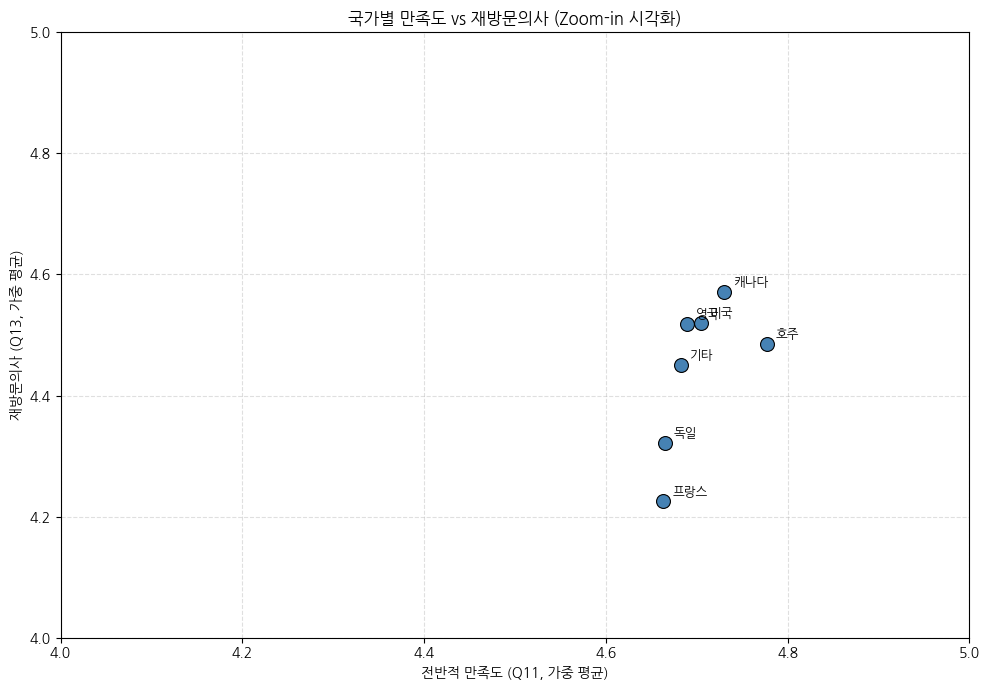

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=country_q13_q11,
    x="Q11_만족도_가중평균",
    y="Q13_재방문_가중평균",
    s=100,
    color="steelblue",
    edgecolor="black"
)

# 국가명 라벨 추가
for i, row in country_q13_q11.iterrows():
    plt.text(row["Q11_만족도_가중평균"] + 0.01,
             row["Q13_재방문_가중평균"] + 0.01,
             row["D_NAT"], fontsize=9)

# 축 라벨, 제목
plt.xlabel("전반적 만족도 (Q11, 가중 평균)")
plt.ylabel("재방문의사 (Q13, 가중 평균)")
plt.title("국가별 만족도 vs 재방문의사 (Zoom-in 시각화)")

# 📌 X, Y축 범위 확대 (예시: 4.2 ~ 4.7)
plt.xlim(4, 5)
plt.ylim(4, 5)

plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


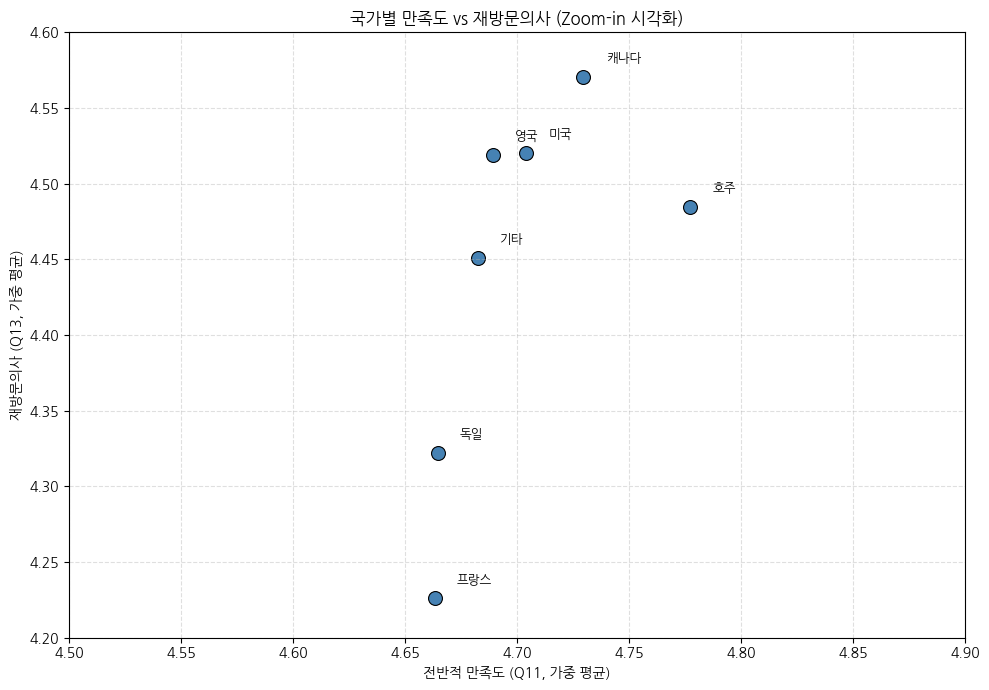

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=country_q13_q11,
    x="Q11_만족도_가중평균",
    y="Q13_재방문_가중평균",
    s=100,
    color="steelblue",
    edgecolor="black"
)

# 국가명 라벨 추가
for i, row in country_q13_q11.iterrows():
    plt.text(row["Q11_만족도_가중평균"] + 0.01,
             row["Q13_재방문_가중평균"] + 0.01,
             row["D_NAT"], fontsize=9)

# 축 라벨, 제목
plt.xlabel("전반적 만족도 (Q11, 가중 평균)")
plt.ylabel("재방문의사 (Q13, 가중 평균)")
plt.title("국가별 만족도 vs 재방문의사 (Zoom-in 시각화)")

# 📌 X, Y축 범위 확대 (예시: 4.2 ~ 4.7)
plt.xlim(4.5, 4.9)
plt.ylim(4.2, 4.6)

plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


| 국가           | Q11 만족도 (X축)   | Q13 재방문 의사 (Y축)    | 해석                                                    |
| ------------ | -------------- | ------------------ | ----------------------------------------------------- |
| **캐나다**      | 높음 (≈4.75)     | 매우 높음 (≈4.57)      | 전반적 만족도도 매우 높고, 재방문 의사도 가장 높은 국가 → 충성도 높은 잠재고객군       |
| **호주**       | 매우 높음 (≈4.78)  | 다소 낮음 (≈4.48)      | 만족도는 가장 높지만 재방문 의사는 상대적으로 낮음 → **거리·비자 등 구조적 장벽** 가능성 |
| **프랑스 / 독일** | 중간\~높음 (≈4.65) | 낮음 (≈4.22 \~ 4.32) | 만족도와 재방문의사 모두 상대적으로 낮음 → **서비스 품질 개선 or 기대 불일치** 가능성  |
| **미국 / 영국**  | 높음 (≈4.72)     | 높음 (≈4.51 \~ 4.52) | 전반적으로 우수한 만족도와 재방문의사 → 안정적 선호 국가                      |
| **기타국가**     | 평균적 (≈4.69)    | 보통 (≈4.45)         | 전체적으로 무난한 인식, 추가적인 홍보 또는 관심 유도 가능                     |


In [ ]:
print(df_cluster1_2024["Q11"].value_counts(dropna=False))


Q11
⑤ 매우 만족     3006
④ 만족        1073
③ 보통          53
① 매우 불만족      20
② 불만족          6
Name: count, dtype: int64


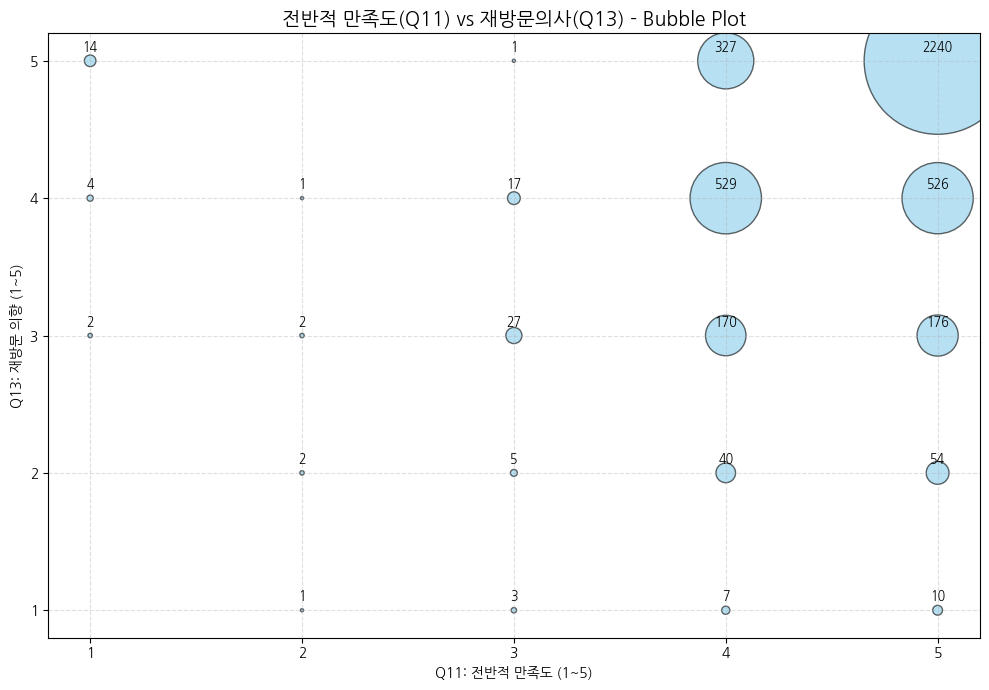

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 문자형 → 수치형 매핑
q11_map = {
    "① 매우 불만족": 1,
    "② 불만족": 2,
    "③ 보통": 3,
    "④ 만족": 4,
    "⑤ 매우 만족": 5
}
q13_map = {
    "① 전혀 그렇지 않다": 1,
    "② 별로 그렇지 않다": 2,
    "③ 보통": 3,
    "④ 대체로 그렇다": 4,
    "⑤ 매우 그렇다": 5
}

df_cluster1_2024["Q11_score"] = df_cluster1_2024["Q11"].map(q11_map)
df_cluster1_2024["Q13_score"] = df_cluster1_2024["Q13"].map(q13_map)

# 2. 유효 응답 필터링
df_valid = df_cluster1_2024.dropna(subset=["Q11_score", "Q13_score"])

# 3. 교차표로 빈도 집계
bubble_data = df_valid.groupby(["Q11_score", "Q13_score"]).size().reset_index(name="count")

# 4. 시각화
plt.figure(figsize=(10, 7))
plt.scatter(
    bubble_data["Q11_score"],
    bubble_data["Q13_score"],
    s=bubble_data["count"] * 5,  # 버블 크기 조정
    alpha=0.6,
    color="skyblue",
    edgecolors="black"
)

# 각 점에 count 수 표시
for _, row in bubble_data.iterrows():
    plt.text(row["Q11_score"], row["Q13_score"] + 0.05, str(row["count"]),
             ha="center", va="bottom", fontsize=9)

# 축 설정
plt.title("전반적 만족도(Q11) vs 재방문의사(Q13) - Bubble Plot", fontsize=14)
plt.xlabel("Q11: 전반적 만족도 (1~5)")
plt.ylabel("Q13: 재방문 의향 (1~5)")
plt.xticks([1, 2, 3, 4, 5])
plt.yticks([1, 2, 3, 4, 5])
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


#### 도출!
➤ 전반적으로 만족도가 높을수록 재방문 의향도 높아지는 뚜렷한 경향 <br>
➤ 만족도가 낮은 경우는 표본 수가 적어 일반화는 어렵지만, 재방문 의향도 낮은 경향 <br>
➤ 만족도 4는 재방문 의사에도 긍정적인 영향을 주지만, 일부 이탈 가능성도 존재 <br>
➤ 재방문 유도 핵심은 전반적 만족도(Q11)를 4점 이상으로 끌어올리는 것이 중요하다고 판단